## Physics Informed Neural Networks to Approximate Solution of PDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

Consider the one-dimensional heat equation:

$$
u_t(t, x) + ((u²)/2)_x = u_{xx}(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$

with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0, 
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

We want to obtain an approximate solution of the heat equation $u : [0,T]\times[-1,1] \mapsto \mathbb{R}$ with physics informed neural networks (PINNs).

To do so, we approximate the underlying solution with a feedforward dense neural network with tunable parameters $\theta$:

$$
u_\theta(t,x) \approx u(t,x)
$$
Define the following residuals:

   - Interior residual given by,

   $$r_{int,\theta}(t, x):=  u_{\theta, t}(x,t) - u_{\theta, xx}(x,t), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
   
        
      
        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta) = \int_{[0,T]\times[-1,1]}r_{int,\theta}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences.

$$
L_{int}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

and solve the following minimization problem

$$
\theta^\ast = argmin_{\theta} \Big(L_{int}(\theta) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta)
$$



In [7]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 0.1],  # Time dimension
                                            [-1, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        return -torch.sin(np.pi * x)

    # Exact solution for the heat equation ut = u_xx with the IC above
    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]

        u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
        return u

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)
        u_sq =  .5 * u ** 2

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]
        
        grad_u_sq_x = torch.autograd.grad(u_sq.sum(), input_int, create_graph=True)[0][:, 1]

        residual = grad_u_t + grad_u_sq_x - .001 * grad_u_xx
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])


        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs).reshape(-1, )
        exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution")
        axs[1].set_title("Approximate Solution")

        plt.show()

        err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
        print("L2 Relative Error Norm: ", err.item(), "%")


In [8]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

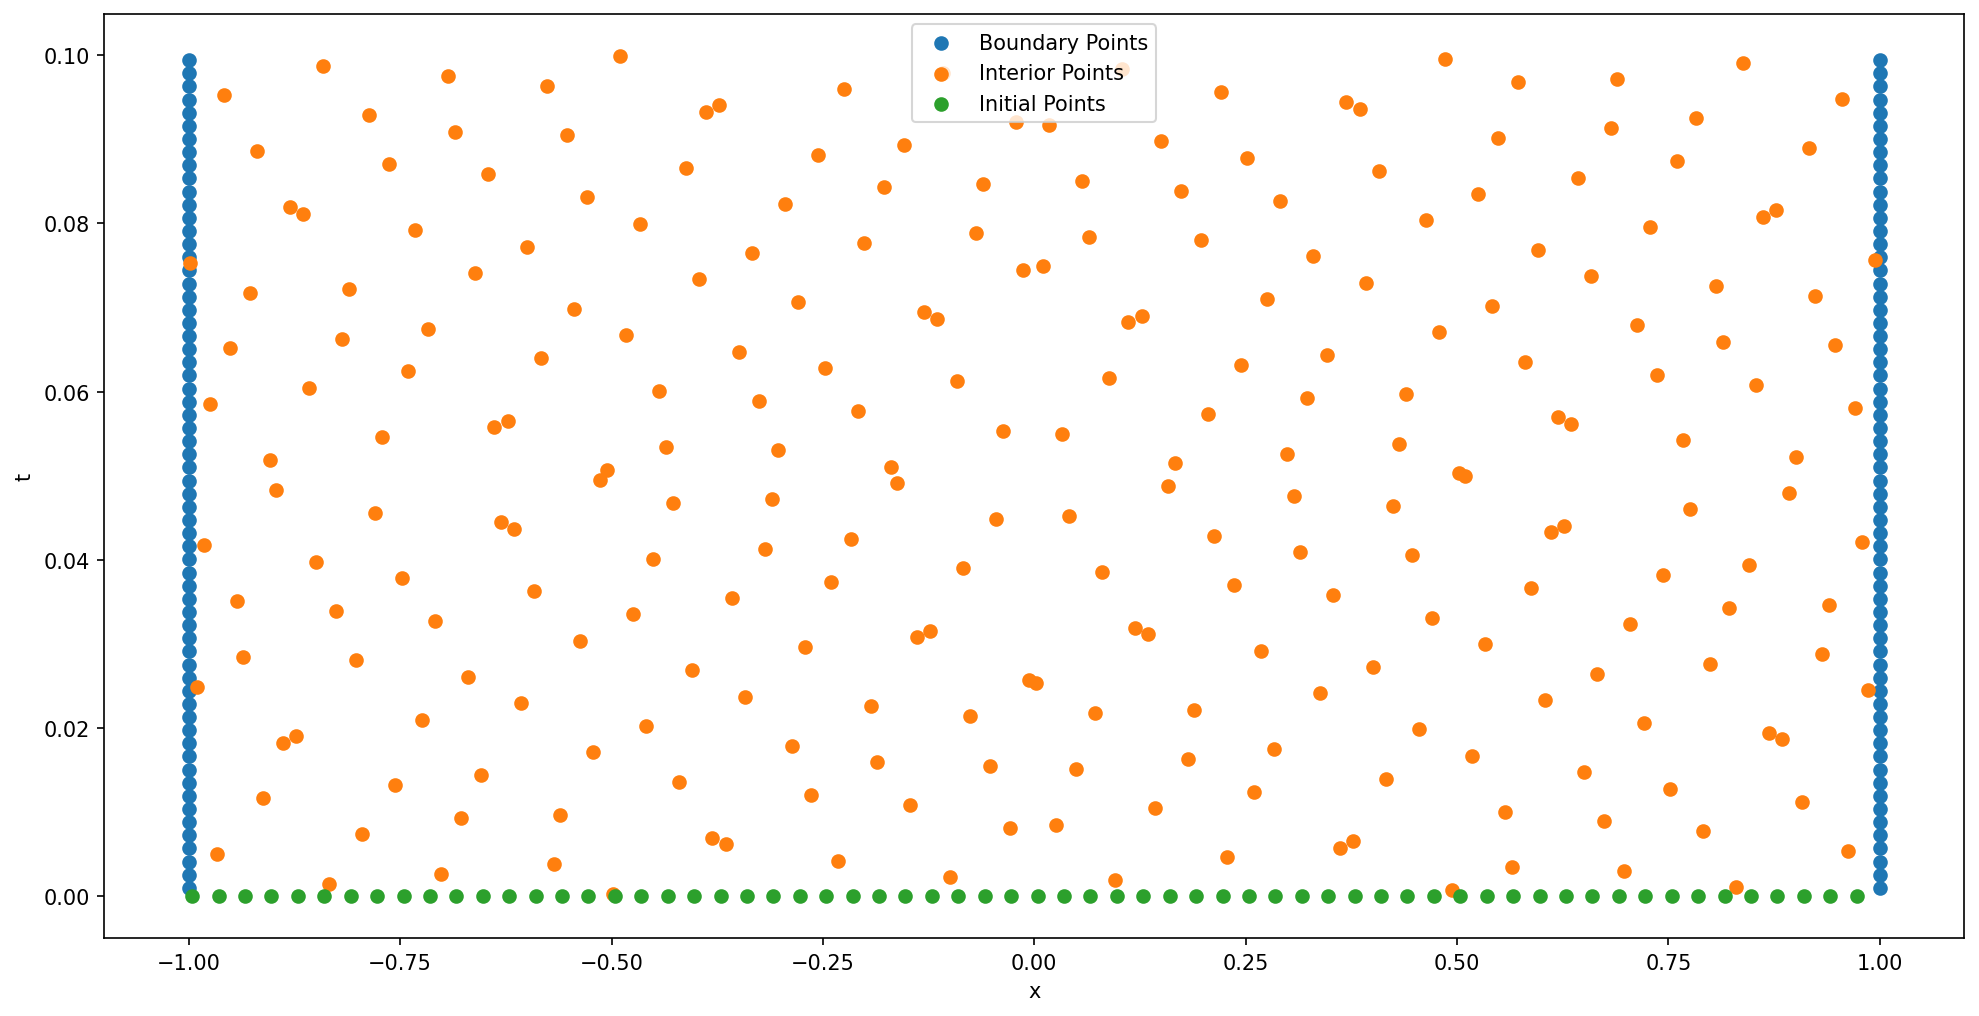

In [9]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [10]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

################################  0  ################################
Total loss:  1.5605 | PDE Loss:  -0.0044 | Function Loss:  1.4224
Total loss:  1.477 | PDE Loss:  -0.127 | Function Loss:  1.3527
Total loss:  1.1604 | PDE Loss:  0.1071 | Function Loss:  0.2229
Total loss:  0.9491 | PDE Loss:  -0.1745 | Function Loss:  0.3429
Total loss:  1.645 | PDE Loss:  0.6093 | Function Loss:  0.5425
Total loss:  0.7747 | PDE Loss:  -0.4563 | Function Loss:  0.3902
Total loss:  0.7198 | PDE Loss:  -0.4687 | Function Loss:  0.2666
Total loss:  0.6407 | PDE Loss:  -0.4941 | Function Loss:  0.0668
Total loss:  0.5785 | PDE Loss:  -0.5298 | Function Loss:  -0.0777
Total loss:  0.5418 | PDE Loss:  -0.5512 | Function Loss:  -0.1731
Total loss:  0.4248 | PDE Loss:  -0.6747 | Function Loss:  -0.2639
Total loss:  0.4042 | PDE Loss:  -0.6801 | Function Loss:  -0.3494
Total loss:  0.3907 | PDE Loss:  -0.6809 | Function Loss:  -0.4277
Total loss:  0.3147 | PDE Loss:  -0.7216 | Function Loss:  -0.7809
Total

Total loss:  -1.9339 | PDE Loss:  -3.3625 | Function Loss:  -2.1365
Total loss:  -1.9355 | PDE Loss:  -3.3614 | Function Loss:  -2.1397
Total loss:  -1.9433 | PDE Loss:  -3.3619 | Function Loss:  -2.1519
Total loss:  -1.9466 | PDE Loss:  -3.3517 | Function Loss:  -2.1637
Total loss:  -1.9485 | PDE Loss:  -3.3544 | Function Loss:  -2.1651
Total loss:  -1.9538 | PDE Loss:  -3.3624 | Function Loss:  -2.1687
Total loss:  -1.9631 | PDE Loss:  -3.3807 | Function Loss:  -2.1723
Total loss:  -1.9749 | PDE Loss:  -3.4159 | Function Loss:  -2.1702
Total loss:  -1.9887 | PDE Loss:  -3.4621 | Function Loss:  -2.1667
Total loss:  -2.0048 | PDE Loss:  -3.5245 | Function Loss:  -2.1611
Total loss:  -2.0298 | PDE Loss:  -3.6181 | Function Loss:  -2.1595
Total loss:  -2.04 | PDE Loss:  -3.6817 | Function Loss:  -2.1525
Total loss:  -2.0683 | PDE Loss:  -3.7279 | Function Loss:  -2.1756
Total loss:  -2.0802 | PDE Loss:  -3.7422 | Function Loss:  -2.1868
Total loss:  -2.0864 | PDE Loss:  -3.7488 | Functi

Total loss:  -2.8037 | PDE Loss:  -4.4103 | Function Loss:  -2.9271
Total loss:  -2.8149 | PDE Loss:  -4.4139 | Function Loss:  -2.9409
Total loss:  -2.8264 | PDE Loss:  -4.407 | Function Loss:  -2.9588
Total loss:  -2.837 | PDE Loss:  -4.3914 | Function Loss:  -2.9791
Total loss:  -2.8452 | PDE Loss:  -4.3794 | Function Loss:  -2.9954
Total loss:  -2.8493 | PDE Loss:  -4.3678 | Function Loss:  -3.0061
Total loss:  -2.8514 | PDE Loss:  -4.3612 | Function Loss:  -3.012
Total loss:  -2.8526 | PDE Loss:  -4.3571 | Function Loss:  -3.0156
Total loss:  -2.8538 | PDE Loss:  -4.3521 | Function Loss:  -3.0197
Total loss:  -2.8549 | PDE Loss:  -4.3524 | Function Loss:  -3.0211
Total loss:  -2.858 | PDE Loss:  -4.3536 | Function Loss:  -3.0251
Total loss:  -2.8622 | PDE Loss:  -4.3607 | Function Loss:  -3.028
Total loss:  -2.8658 | PDE Loss:  -4.3651 | Function Loss:  -3.0312
Total loss:  -2.8686 | PDE Loss:  -4.3698 | Function Loss:  -3.0332
Total loss:  -2.871 | PDE Loss:  -4.3738 | Function L

Total loss:  -3.3281 | PDE Loss:  -5.1213 | Function Loss:  -3.4044
Total loss:  -3.3302 | PDE Loss:  -5.128 | Function Loss:  -3.4056
Total loss:  -3.3318 | PDE Loss:  -5.133 | Function Loss:  -3.4065
Total loss:  -3.3329 | PDE Loss:  -5.1341 | Function Loss:  -3.4076
Total loss:  -3.3335 | PDE Loss:  -5.1333 | Function Loss:  -3.4085
Total loss:  -3.3338 | PDE Loss:  -5.1311 | Function Loss:  -3.4092
Total loss:  -3.334 | PDE Loss:  -5.1296 | Function Loss:  -3.4098
Total loss:  -3.3341 | PDE Loss:  -5.128 | Function Loss:  -3.4102
Total loss:  -3.3344 | PDE Loss:  -5.1257 | Function Loss:  -3.4109
Total loss:  -3.3346 | PDE Loss:  -5.1248 | Function Loss:  -3.4115
Total loss:  -3.3352 | PDE Loss:  -5.1236 | Function Loss:  -3.4123
Total loss:  -3.3362 | PDE Loss:  -5.1236 | Function Loss:  -3.4135
Total loss:  -3.3377 | PDE Loss:  -5.1251 | Function Loss:  -3.415
Total loss:  -3.3401 | PDE Loss:  -5.128 | Function Loss:  -3.4173
Total loss:  -3.3428 | PDE Loss:  -5.1367 | Function L

Total loss:  -3.5678 | PDE Loss:  -5.1578 | Function Loss:  -3.6968
Total loss:  -3.5682 | PDE Loss:  -5.1563 | Function Loss:  -3.6979
Total loss:  -3.5686 | PDE Loss:  -5.1559 | Function Loss:  -3.6986
Total loss:  -3.5689 | PDE Loss:  -5.1538 | Function Loss:  -3.6997
Total loss:  -3.5692 | PDE Loss:  -5.1507 | Function Loss:  -3.7012
Total loss:  -3.5697 | PDE Loss:  -5.1486 | Function Loss:  -3.7026
Total loss:  -3.5705 | PDE Loss:  -5.1445 | Function Loss:  -3.7052
Total loss:  -3.5719 | PDE Loss:  -5.1405 | Function Loss:  -3.7085
Total loss:  -3.574 | PDE Loss:  -5.1322 | Function Loss:  -3.7146
Total loss:  -3.5753 | PDE Loss:  -5.1249 | Function Loss:  -3.7193
Total loss:  -3.5776 | PDE Loss:  -5.1212 | Function Loss:  -3.7239
Total loss:  -3.5797 | PDE Loss:  -5.1147 | Function Loss:  -3.7296
Total loss:  -3.5815 | PDE Loss:  -5.116 | Function Loss:  -3.7315
Total loss:  -3.5835 | PDE Loss:  -5.1171 | Function Loss:  -3.7339
Total loss:  -3.5855 | PDE Loss:  -5.123 | Functio

Total loss:  -3.7793 | PDE Loss:  -5.3371 | Function Loss:  -3.92
Total loss:  -3.7812 | PDE Loss:  -5.3404 | Function Loss:  -3.9215
Total loss:  -3.7838 | PDE Loss:  -5.3422 | Function Loss:  -3.9244
Total loss:  -3.7869 | PDE Loss:  -5.3517 | Function Loss:  -3.925
Total loss:  -3.7906 | PDE Loss:  -5.3678 | Function Loss:  -3.9241
Total loss:  -3.7936 | PDE Loss:  -5.3828 | Function Loss:  -3.9229
Total loss:  -3.7962 | PDE Loss:  -5.3913 | Function Loss:  -3.9235
Total loss:  -3.801 | PDE Loss:  -5.4063 | Function Loss:  -3.9248
Total loss:  -3.8044 | PDE Loss:  -5.4158 | Function Loss:  -3.9263
Total loss:  -3.8074 | PDE Loss:  -5.4177 | Function Loss:  -3.9296
Total loss:  -3.8102 | PDE Loss:  -5.4201 | Function Loss:  -3.9325
Total loss:  -3.8134 | PDE Loss:  -5.4168 | Function Loss:  -3.9379
Total loss:  -3.8158 | PDE Loss:  -5.413 | Function Loss:  -3.9423
Total loss:  -3.8185 | PDE Loss:  -5.4091 | Function Loss:  -3.9473
Total loss:  -3.8217 | PDE Loss:  -5.4104 | Function 

Total loss:  -4.1421 | PDE Loss:  -5.8407 | Function Loss:  -4.2391
Total loss:  -4.143 | PDE Loss:  -5.8403 | Function Loss:  -4.2403
Total loss:  -4.1447 | PDE Loss:  -5.8432 | Function Loss:  -4.2418
Total loss:  -4.1473 | PDE Loss:  -5.8494 | Function Loss:  -4.2434
Total loss:  -4.1501 | PDE Loss:  -5.8604 | Function Loss:  -4.2442
Total loss:  -4.1524 | PDE Loss:  -5.8719 | Function Loss:  -4.2443
Total loss:  -4.1541 | PDE Loss:  -5.8877 | Function Loss:  -4.2428
Total loss:  -4.1551 | PDE Loss:  -5.8971 | Function Loss:  -4.2419
Total loss:  -4.1557 | PDE Loss:  -5.9065 | Function Loss:  -4.2406
Total loss:  -4.156 | PDE Loss:  -5.9118 | Function Loss:  -4.2398
Total loss:  -4.1564 | PDE Loss:  -5.9188 | Function Loss:  -4.2388
Total loss:  -4.1569 | PDE Loss:  -5.9265 | Function Loss:  -4.2379
Total loss:  -4.1578 | PDE Loss:  -5.9407 | Function Loss:  -4.2361
Total loss:  -4.1593 | PDE Loss:  -5.9564 | Function Loss:  -4.2348
Total loss:  -4.1612 | PDE Loss:  -5.981 | Functio

Total loss:  -4.5939 | PDE Loss:  -6.4152 | Function Loss:  -4.665
Total loss:  -4.5989 | PDE Loss:  -6.4242 | Function Loss:  -4.6693
Total loss:  -4.6022 | PDE Loss:  -6.4387 | Function Loss:  -4.6706
Total loss:  -4.6047 | PDE Loss:  -6.4508 | Function Loss:  -4.6715
Total loss:  -4.6068 | PDE Loss:  -6.4611 | Function Loss:  -4.6722
Total loss:  -4.6084 | PDE Loss:  -6.4678 | Function Loss:  -4.673
Total loss:  -4.6095 | PDE Loss:  -6.4688 | Function Loss:  -4.6741
Total loss:  -4.6105 | PDE Loss:  -6.4661 | Function Loss:  -4.6757
Total loss:  -4.6115 | PDE Loss:  -6.4631 | Function Loss:  -4.6773
Total loss:  -4.6125 | PDE Loss:  -6.4585 | Function Loss:  -4.6794
Total loss:  -4.6136 | PDE Loss:  -6.4537 | Function Loss:  -4.6814
Total loss:  -4.6144 | PDE Loss:  -6.4497 | Function Loss:  -4.683
Total loss:  -4.6151 | PDE Loss:  -6.4484 | Function Loss:  -4.6841
Total loss:  -4.6158 | PDE Loss:  -6.4491 | Function Loss:  -4.6847
Total loss:  -4.6166 | PDE Loss:  -6.4512 | Functio

Total loss:  -4.7932 | PDE Loss:  -6.6022 | Function Loss:  -4.8664
Total loss:  -4.7938 | PDE Loss:  -6.6069 | Function Loss:  -4.8663
Total loss:  -4.7939 | PDE Loss:  -6.6081 | Function Loss:  -4.8662
Total loss:  -4.7941 | PDE Loss:  -6.6094 | Function Loss:  -4.8663
Total loss:  -4.7947 | PDE Loss:  -6.6116 | Function Loss:  -4.8665
Total loss:  -4.7953 | PDE Loss:  -6.613 | Function Loss:  -4.867
Total loss:  -4.796 | PDE Loss:  -6.6134 | Function Loss:  -4.8677
Total loss:  -4.7968 | PDE Loss:  -6.6128 | Function Loss:  -4.8688
Total loss:  -4.7981 | PDE Loss:  -6.6114 | Function Loss:  -4.8706
Total loss:  -4.8 | PDE Loss:  -6.6096 | Function Loss:  -4.8731
Total loss:  -4.8027 | PDE Loss:  -6.6081 | Function Loss:  -4.8766
Total loss:  -4.8062 | PDE Loss:  -6.6073 | Function Loss:  -4.8809
Total loss:  -4.8102 | PDE Loss:  -6.6075 | Function Loss:  -4.8857
Total loss:  -4.814 | PDE Loss:  -6.6073 | Function Loss:  -4.8902
Total loss:  -4.8175 | PDE Loss:  -6.6112 | Function Lo

Total loss:  -4.9347 | PDE Loss:  -6.9534 | Function Loss:  -4.9785
Total loss:  -4.9361 | PDE Loss:  -6.9609 | Function Loss:  -4.9792
Total loss:  -4.9377 | PDE Loss:  -6.963 | Function Loss:  -4.9808
Total loss:  -4.94 | PDE Loss:  -6.984 | Function Loss:  -4.9812
Total loss:  -4.9411 | PDE Loss:  -6.9867 | Function Loss:  -4.982
Total loss:  -4.943 | PDE Loss:  -6.9934 | Function Loss:  -4.9835
Total loss:  -4.9441 | PDE Loss:  -6.997 | Function Loss:  -4.9844
Total loss:  -4.9447 | PDE Loss:  -6.9923 | Function Loss:  -4.9855
Total loss:  -4.9451 | PDE Loss:  -6.9964 | Function Loss:  -4.9855
Total loss:  -4.9453 | PDE Loss:  -7.0002 | Function Loss:  -4.9854
Total loss:  -4.9456 | PDE Loss:  -7.0054 | Function Loss:  -4.9852
Total loss:  -4.9458 | PDE Loss:  -7.0106 | Function Loss:  -4.9849
Total loss:  -4.9459 | PDE Loss:  -7.0159 | Function Loss:  -4.9846
Total loss:  -4.946 | PDE Loss:  -7.0191 | Function Loss:  -4.9844
Total loss:  -4.9461 | PDE Loss:  -7.021 | Function Loss

Total loss:  -4.993 | PDE Loss:  -6.9807 | Function Loss:  -5.0401
Total loss:  -4.9935 | PDE Loss:  -6.9841 | Function Loss:  -5.0404
Total loss:  -4.9943 | PDE Loss:  -6.987 | Function Loss:  -5.0409
Total loss:  -4.9952 | PDE Loss:  -6.9943 | Function Loss:  -5.041
Total loss:  -4.9961 | PDE Loss:  -6.9961 | Function Loss:  -5.0418
Total loss:  -4.9972 | PDE Loss:  -6.9973 | Function Loss:  -5.043
Total loss:  -4.9988 | PDE Loss:  -6.9971 | Function Loss:  -5.0447
Total loss:  -5.0002 | PDE Loss:  -6.9904 | Function Loss:  -5.0471
Total loss:  -5.0015 | PDE Loss:  -6.986 | Function Loss:  -5.049
Total loss:  -5.0024 | PDE Loss:  -6.9807 | Function Loss:  -5.0507
Total loss:  -5.004 | PDE Loss:  -6.9737 | Function Loss:  -5.0533
Total loss:  -5.006 | PDE Loss:  -6.9613 | Function Loss:  -5.057
Total loss:  -5.0081 | PDE Loss:  -6.952 | Function Loss:  -5.0606
Total loss:  -5.0106 | PDE Loss:  -6.9395 | Function Loss:  -5.065
Total loss:  -5.0129 | PDE Loss:  -6.9299 | Function Loss: 

Total loss:  -5.1011 | PDE Loss:  -6.9555 | Function Loss:  -5.1665
Total loss:  -5.1012 | PDE Loss:  -6.9548 | Function Loss:  -5.1668
Total loss:  -5.1014 | PDE Loss:  -6.9533 | Function Loss:  -5.1673
Total loss:  -5.1015 | PDE Loss:  -6.9511 | Function Loss:  -5.1677
Total loss:  -5.1017 | PDE Loss:  -6.9475 | Function Loss:  -5.1685
Total loss:  -5.1018 | PDE Loss:  -6.945 | Function Loss:  -5.1691
Total loss:  -5.102 | PDE Loss:  -6.9417 | Function Loss:  -5.1699
Total loss:  -5.1023 | PDE Loss:  -6.9393 | Function Loss:  -5.1706
Total loss:  -5.1025 | PDE Loss:  -6.9353 | Function Loss:  -5.1716
Total loss:  -5.1022 | PDE Loss:  -6.9299 | Function Loss:  -5.1721
Total loss:  -5.1028 | PDE Loss:  -6.9343 | Function Loss:  -5.1721
Total loss:  -5.1031 | PDE Loss:  -6.9343 | Function Loss:  -5.1724
Total loss:  -5.1037 | PDE Loss:  -6.9341 | Function Loss:  -5.1732
Total loss:  -5.1045 | PDE Loss:  -6.9383 | Function Loss:  -5.1733
Total loss:  -5.1052 | PDE Loss:  -6.9462 | Functi

Total loss:  -5.1772 | PDE Loss:  -6.8986 | Function Loss:  -5.2687
Total loss:  -5.1774 | PDE Loss:  -6.8998 | Function Loss:  -5.2686
Total loss:  -5.1776 | PDE Loss:  -6.9013 | Function Loss:  -5.2685
Total loss:  -5.1778 | PDE Loss:  -6.9033 | Function Loss:  -5.2683
Total loss:  -5.1779 | PDE Loss:  -6.9054 | Function Loss:  -5.268
Total loss:  -5.178 | PDE Loss:  -6.9073 | Function Loss:  -5.2677
Total loss:  -5.1782 | PDE Loss:  -6.9096 | Function Loss:  -5.2673
Total loss:  -5.1783 | PDE Loss:  -6.9127 | Function Loss:  -5.2668
Total loss:  -5.1785 | PDE Loss:  -6.9151 | Function Loss:  -5.2665
Total loss:  -5.1786 | PDE Loss:  -6.9197 | Function Loss:  -5.2656
Total loss:  -5.1788 | PDE Loss:  -6.9214 | Function Loss:  -5.2654
Total loss:  -5.1789 | PDE Loss:  -6.9228 | Function Loss:  -5.2652
Total loss:  -5.1789 | PDE Loss:  -6.9241 | Function Loss:  -5.265
Total loss:  -5.179 | PDE Loss:  -6.9249 | Function Loss:  -5.2649
Total loss:  -5.1791 | PDE Loss:  -6.926 | Function 

Total loss:  -5.2847 | PDE Loss:  -7.1545 | Function Loss:  -5.3476
Total loss:  -5.2848 | PDE Loss:  -7.1536 | Function Loss:  -5.3479
Total loss:  -5.2849 | PDE Loss:  -7.153 | Function Loss:  -5.3481
Total loss:  -5.2851 | PDE Loss:  -7.1513 | Function Loss:  -5.3486
Total loss:  -5.2854 | PDE Loss:  -7.1512 | Function Loss:  -5.349
Total loss:  -5.2857 | PDE Loss:  -7.1509 | Function Loss:  -5.3494
Total loss:  -5.2861 | PDE Loss:  -7.1515 | Function Loss:  -5.3497
Total loss:  -5.2864 | PDE Loss:  -7.1525 | Function Loss:  -5.35
Total loss:  -5.2867 | PDE Loss:  -7.1539 | Function Loss:  -5.3501
Total loss:  -5.2871 | PDE Loss:  -7.1569 | Function Loss:  -5.3501
Total loss:  -5.2873 | PDE Loss:  -7.1599 | Function Loss:  -5.3499
Total loss:  -5.2876 | PDE Loss:  -7.1618 | Function Loss:  -5.3499
Total loss:  -5.2877 | PDE Loss:  -7.1645 | Function Loss:  -5.3496
Total loss:  -5.2879 | PDE Loss:  -7.1667 | Function Loss:  -5.3495
Total loss:  -5.2882 | PDE Loss:  -7.169 | Function 

Total loss:  -5.3726 | PDE Loss:  -7.3006 | Function Loss:  -5.4272
Total loss:  -5.3736 | PDE Loss:  -7.3039 | Function Loss:  -5.4278
Total loss:  -5.3742 | PDE Loss:  -7.3041 | Function Loss:  -5.4285
Total loss:  -5.3746 | PDE Loss:  -7.3071 | Function Loss:  -5.4285
Total loss:  -5.3751 | PDE Loss:  -7.3083 | Function Loss:  -5.429
Total loss:  -5.3758 | PDE Loss:  -7.3083 | Function Loss:  -5.4298
Total loss:  -5.3765 | PDE Loss:  -7.3059 | Function Loss:  -5.4308
Total loss:  -5.377 | PDE Loss:  -7.3023 | Function Loss:  -5.432
Total loss:  -5.3776 | PDE Loss:  -7.2977 | Function Loss:  -5.4332
Total loss:  -5.3782 | PDE Loss:  -7.2928 | Function Loss:  -5.4345
Total loss:  -5.3786 | PDE Loss:  -7.2857 | Function Loss:  -5.4361
Total loss:  -5.379 | PDE Loss:  -7.2843 | Function Loss:  -5.4367
Total loss:  -5.3796 | PDE Loss:  -7.283 | Function Loss:  -5.4376
Total loss:  -5.3803 | PDE Loss:  -7.2863 | Function Loss:  -5.4379
Total loss:  -5.381 | PDE Loss:  -7.2885 | Function L

Total loss:  -5.4297 | PDE Loss:  -7.2932 | Function Loss:  -5.4936
Total loss:  -5.4307 | PDE Loss:  -7.2971 | Function Loss:  -5.4942
Total loss:  -5.4313 | PDE Loss:  -7.2982 | Function Loss:  -5.4947
Total loss:  -5.4326 | PDE Loss:  -7.3002 | Function Loss:  -5.4959
Total loss:  -5.4334 | PDE Loss:  -7.3028 | Function Loss:  -5.4964
Total loss:  -5.4341 | PDE Loss:  -7.3038 | Function Loss:  -5.4971
Total loss:  -5.4347 | PDE Loss:  -7.3051 | Function Loss:  -5.4976
Total loss:  -5.4352 | PDE Loss:  -7.3058 | Function Loss:  -5.4981
Total loss:  -5.4357 | PDE Loss:  -7.3073 | Function Loss:  -5.4983
Total loss:  -5.4362 | PDE Loss:  -7.3097 | Function Loss:  -5.4986
Total loss:  -5.4367 | PDE Loss:  -7.3119 | Function Loss:  -5.4988
Total loss:  -5.437 | PDE Loss:  -7.3136 | Function Loss:  -5.4989
Total loss:  -5.4374 | PDE Loss:  -7.3142 | Function Loss:  -5.4993
Total loss:  -5.4377 | PDE Loss:  -7.3142 | Function Loss:  -5.4996
Total loss:  -5.4381 | PDE Loss:  -7.3133 | Funct

Total loss:  -5.4618 | PDE Loss:  -7.3444 | Function Loss:  -5.5228
Total loss:  -5.462 | PDE Loss:  -7.3452 | Function Loss:  -5.523
Total loss:  -5.4625 | PDE Loss:  -7.3457 | Function Loss:  -5.5234
Total loss:  -5.463 | PDE Loss:  -7.3452 | Function Loss:  -5.524
Total loss:  -5.4634 | PDE Loss:  -7.3442 | Function Loss:  -5.5247
Total loss:  -5.4638 | PDE Loss:  -7.3417 | Function Loss:  -5.5255
Total loss:  -5.4643 | PDE Loss:  -7.3401 | Function Loss:  -5.5264
Total loss:  -5.465 | PDE Loss:  -7.3359 | Function Loss:  -5.5278
Total loss:  -5.4655 | PDE Loss:  -7.3345 | Function Loss:  -5.5286
Total loss:  -5.4661 | PDE Loss:  -7.3343 | Function Loss:  -5.5293
Total loss:  -5.4672 | PDE Loss:  -7.3332 | Function Loss:  -5.5307
Total loss:  -5.468 | PDE Loss:  -7.3341 | Function Loss:  -5.5316
Total loss:  -5.4689 | PDE Loss:  -7.3344 | Function Loss:  -5.5325
Total loss:  -5.4701 | PDE Loss:  -7.3374 | Function Loss:  -5.5335
Total loss:  -5.4712 | PDE Loss:  -7.3364 | Function L

Total loss:  -5.5562 | PDE Loss:  -7.4456 | Function Loss:  -5.6161
Total loss:  -5.5568 | PDE Loss:  -7.4486 | Function Loss:  -5.6164
Total loss:  -5.5573 | PDE Loss:  -7.4554 | Function Loss:  -5.616
Total loss:  -5.5578 | PDE Loss:  -7.4601 | Function Loss:  -5.6159
Total loss:  -5.5583 | PDE Loss:  -7.4665 | Function Loss:  -5.6156
Total loss:  -5.5585 | PDE Loss:  -7.4729 | Function Loss:  -5.615
Total loss:  -5.5591 | PDE Loss:  -7.4757 | Function Loss:  -5.6151
Total loss:  -5.5594 | PDE Loss:  -7.4805 | Function Loss:  -5.6149
Total loss:  -5.5596 | PDE Loss:  -7.4828 | Function Loss:  -5.6148
Total loss:  -5.5597 | PDE Loss:  -7.4851 | Function Loss:  -5.6146
Total loss:  -5.56 | PDE Loss:  -7.4875 | Function Loss:  -5.6146
Total loss:  -5.5601 | PDE Loss:  -7.4892 | Function Loss:  -5.6145
Total loss:  -5.5603 | PDE Loss:  -7.4903 | Function Loss:  -5.6146
Total loss:  -5.5605 | PDE Loss:  -7.4913 | Function Loss:  -5.6147
Total loss:  -5.5607 | PDE Loss:  -7.4915 | Function

Total loss:  -5.61 | PDE Loss:  -7.4864 | Function Loss:  -5.6719
Total loss:  -5.6106 | PDE Loss:  -7.4833 | Function Loss:  -5.6731
Total loss:  -5.6112 | PDE Loss:  -7.4848 | Function Loss:  -5.6735
Total loss:  -5.6116 | PDE Loss:  -7.4845 | Function Loss:  -5.6741
Total loss:  -5.6122 | PDE Loss:  -7.4863 | Function Loss:  -5.6745
Total loss:  -5.6129 | PDE Loss:  -7.491 | Function Loss:  -5.6746
Total loss:  -5.6135 | PDE Loss:  -7.4948 | Function Loss:  -5.6747
Total loss:  -5.6141 | PDE Loss:  -7.5003 | Function Loss:  -5.6746
Total loss:  -5.6131 | PDE Loss:  -7.4971 | Function Loss:  -5.6739
Total loss:  -5.6144 | PDE Loss:  -7.5006 | Function Loss:  -5.6748
Total loss:  -5.615 | PDE Loss:  -7.5052 | Function Loss:  -5.6749
Total loss:  -5.6156 | PDE Loss:  -7.5078 | Function Loss:  -5.6751
Total loss:  -5.616 | PDE Loss:  -7.5117 | Function Loss:  -5.6751
Total loss:  -5.6164 | PDE Loss:  -7.5134 | Function Loss:  -5.6753
Total loss:  -5.6167 | PDE Loss:  -7.5152 | Function 

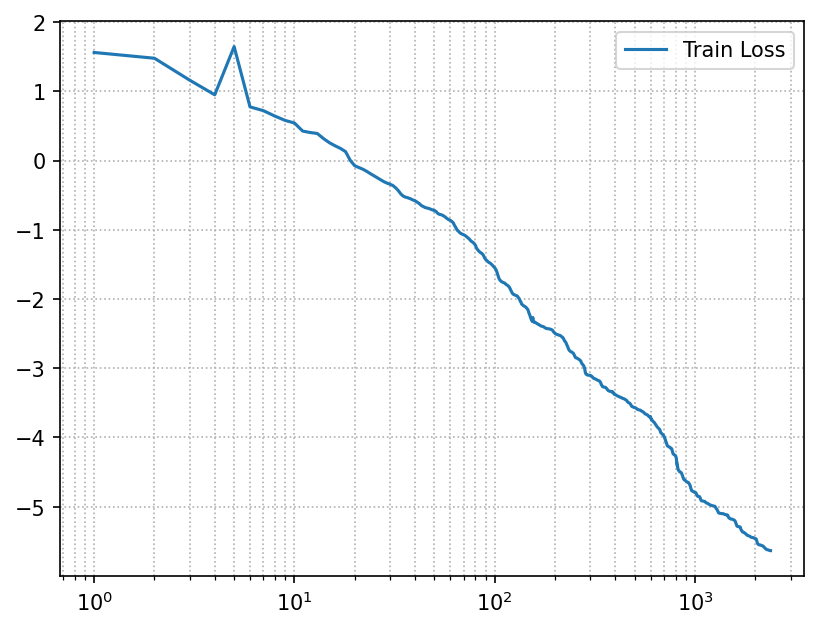

In [11]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

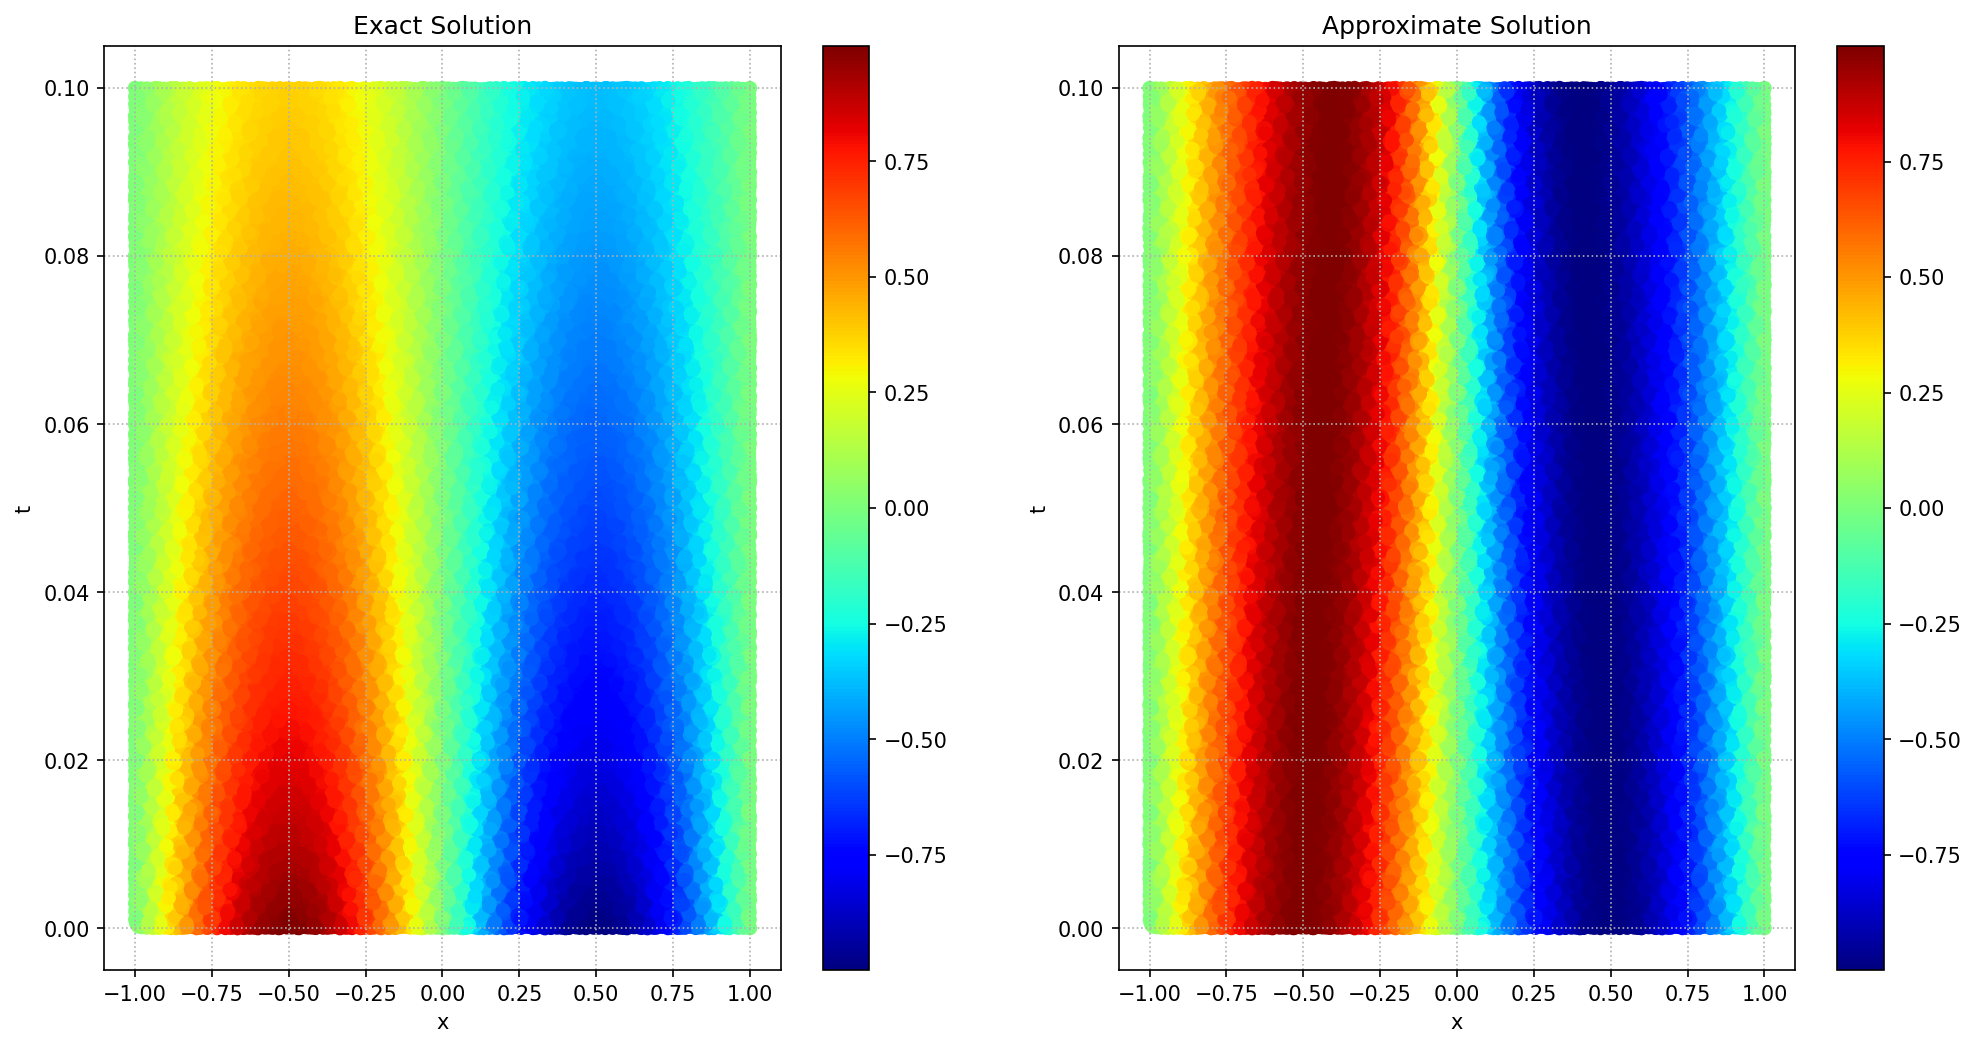

L2 Relative Error Norm:  62.164955139160156 %


In [12]:
pinn.plotting()